# CMPS 4010
## Milestone 5: Unrealized Volatility Prediction
### By Alex Olteanu and Shira Rozenthal

### Next steps

**IN PROGRESS**
- Create M5.ipynb: Remove irrelevant code, focus on preprocessing data for feature engineering.

- Feature Engineering: Implement features Shira suggested; explore others with high correlation.

- Experiment: Test various feature combinations, aim for lowest test error.

- Research: Explore many-to-one, sequential, and time-series models for handling large datasets without data loss due to flattening.

- Understand: Grasp how these models function and how feature engineering effects differing models. Ex: From time series to single model applications.


### Setup

In [34]:
%cd /Users/alexolteanu/Desktop/Spring-2024/CS Capstone II/Kaggle Data/optiver-realized-volatility-prediction

/Users/alexolteanu/Desktop/Spring-2024/CS Capstone II/Kaggle Data/optiver-realized-volatility-prediction


/Users/alexolteanu/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [1]:
%cd /Users/shirarozenthal/Documents/CS/Git/optiver-realized-volatility-prediction

/Users/shirarozenthal/Documents/CS/Git/optiver-realized-volatility-prediction


In [2]:
# Standard libraries
import os
import time
import glob
from contextlib import contextmanager

# Test

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Parallel processing
from joblib import Parallel, delayed

# Set matplotlib to display inline and pandas option
%matplotlib inline
pd.set_option('display.max_columns', None)

### Tutorial Notebook Imports

In [3]:
# Load train data
train = pd.read_csv('train.csv')

# Load test data
test = pd.read_csv('test.csv')

# Initialize stock_id
stock_id = 0

# Load book data
book_example = pd.read_parquet('book_train.parquet/stock_id=0')

# Load trade data
trade_example = pd.read_parquet('trade_train.parquet/stock_id=0')

# Reassign book_example to only include stock_id 0
book_example = book_example[book_example['time_id']==5]

# Create stock_id column in book_example
book_example.loc[:,'stock_id'] = stock_id

# Reassign trade_example to only include stock_id 0
trade_example = trade_example[trade_example['time_id']==5]

# Create stock_id column in trade_example
trade_example.loc[:,'stock_id'] = stock_id

In [4]:
# Generate a WAP feature for example book df
# WAP = (bid_price1 * ask_size1 + ask_price1 * bid_size1) / (bid_size1 + ask_size1)
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

# Define function for computing log returns
# Log return = log(current price / previous price)
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

# Generate a log return column for book_example df
# Takes the log return of the current row and previous row 
# Row zero omitted because it cannot be compared to a previous time entry using ~ operator
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

# Define a function to compute realized volatility using the log returns in a time bucket
# Computed by taking the square root of the sum of squared log returns
# # Realized volatility = sqrt(sum(log returns^2))
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

realized_vol = realized_volatility(book_example['log_return'])

In [5]:
# Create a list of all file paths within book training parquet file
list_order_book_file_train = glob.glob('book_train.parquet/*')

In [6]:
# Define a function for computing the realitized volatiltiy for each time bucket for a specific stock
def realized_volatility_per_time_id(file_path, prediction_column_name):
    # Load the parquet file for a specific stock into a DataFrame
    df_book_data = pd.read_parquet(file_path)

    # Compute the Weighted Average Price (WAP) using bid and ask prices and sizes
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data['ask_size1'])

    # Calculate the log returns of WAP for each 'time_id'
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)

    # Remove rows with NaN values in the 'log_return' column
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]

    # Compute the realized volatility for each 'time_id' based on the log returns
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()

    # Rename the 'log_return' column to the provided prediction_column_name
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})

    # Extract the stock_id from the file_path
    stock_id = file_path.split('=')[1]

    # Create a 'row_id' column combining the stock_id and time_id
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')

    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [7]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    # Initialize an empty DataFrame to store the results for all stocks
    df_past_realized = pd.DataFrame()

    # Loop through each file in the provided list (each file corresponds to a stock's data)
    for file in list_file:
        # Compute the realized volatility for the current stock using the function 'realized_volatility_per_time_id'
        # This function returns the realized volatility for each 'time_id' of the current stock
        df_single_stock_realized_vol = realized_volatility_per_time_id(file, prediction_column_name)

        # Concatenate the results for the current stock with the aggregated results
        df_past_realized = pd.concat([df_past_realized, df_single_stock_realized_vol])

    # Return the aggregated results for all stocks
    return df_past_realized

# Calculate the realized volatility for all stocks in the training data
# The list 'list_order_book_file_train' contains file paths for all stocks in the training set
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train, prediction_column_name='pvol')

/var/folders/vt/9fdy65x9687b115fpdn7jlpw0000gn/T/ipykernel_19161/2202599754.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
/var/folders/vt/9fdy65x9687b115fpdn7jlpw0000gn/T/ipykernel_19161/2202599754.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this war

In [41]:
# Create a new column 'row_id' in the 'train' dataframe. This column is a combination of the 'stock_id' and 'time_id' columns.
# The two values are separated by a '-' and both are converted to string type to facilitate concatenation.
train_mod = pd.read_csv('train.csv')

train_mod['row_id'] = train['stock_id'].astype(str) + '-' + train_mod['time_id'].astype(str)

# Update the 'train' dataframe to keep only the 'row_id' and 'target' columns.
train_mod = train_mod[['row_id','target']]

# Merge the 'train' dataframe with the 'df_past_realized_train' dataframe.
# The merging is based on the 'row_id' column, which is common between the two dataframes.
# This is a left merge, which means all the rows from the 'train' dataframe will be retained and corresponding
# values from 'df_past_realized_train' will be added wherever there's a match based on 'row_id'.
# If there's no match for a particular 'row_id' in 'df_past_realized_train', NaN values will be filled for 'pred' column.
df_joined = train_mod.merge(df_past_realized_train[['row_id','pvol']], on = ['row_id'], how = 'left')

In [42]:
from sklearn.metrics import r2_score

# Define a function to calculate the Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_true, y_pred):
    # The formula for RMSPE is the square root of the average of squared percentage errors.
    # The percentage error is calculated as (actual - predicted) / actual, squared to penalize larger errors.
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# Calculate the R^2 score using the true target values and the predicted values from the 'df_joined' dataframe.
# The R^2 score measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
# It provides a measure of how well the observed outcomes are replicated by the model.
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pvol']),3)

# Calculate the RMSPE using the true target values and the predicted values from the 'df_joined' dataframe.
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pvol']),3)

# Print out the calculated R^2 score and RMSPE.
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


### Reversing Time-ID order

In [43]:
@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")


def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick

def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df

def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents

def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob('book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])

    return df_ordered[['time_id']]

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_9680/3112154199.py:33: SyntaxWarning: invalid escape sequence '\d'
  .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')


[load files] 0.014sec
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


<unknown>:1: SyntaxWarning: invalid escape sequence '\d'


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Do

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_9680/3112154199.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_prices = df_prices.pivot('time_id', 'stock_id', 'price')


[t-SNE(400) -> 50] 381.247sec


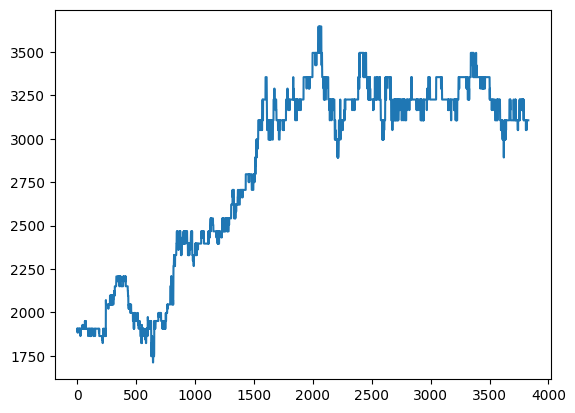

In [44]:
df_ordered = reconstruct_time_id_order()

### Feature Engineering

#### Neighboring Volatility Features

In [82]:
# Create a list of all file paths within book training parquet file
list_order_book_file_train = glob.glob('book_train.parquet/*')

# Create a list of all file paths within trade training parquet file
list_order_trade_file_train = glob.glob('trade_train.parquet/*')

In [83]:
# 
master = df_joined

# 
master = master.rename(columns={'pvol': 'realized_vol'})

# Set the 'order' column of df_ordered to be its index values
df_ordered['order'] = df_ordered.index 

In [84]:
# Merge 'train' DataFrame with 'df_ordered' based on the 'time_id' column
# This is a left join, which means all rows from 'train' will be kept, 
# along with matched rows from 'df_ordered'
merged_df = pd.merge(train, df_ordered, on='time_id', how='left')

# Sort the merged DataFrame first by 'stock_id' and then by 'order'
merged_df.sort_values(by=['stock_id', 'order'], inplace=True)

# Create a new 'row_id' column by concatenating 'stock_id' and 'time_id' as strings
merged_df['row_id'] = merged_df['stock_id'].astype(str) + '-' + merged_df['time_id'].astype(str)

# Reorder columns so that 'row_id' is the first column, and retain all other columns
cols = ['row_id'] + [col for col in merged_df.columns if col != 'row_id']
df_merged = merged_df[cols]

# Drop 'stock_id' and 'time_id' columns from the DataFrame
df_merged = df_merged.drop(['stock_id', 'time_id'], axis=1)

# Swap the positions of the second and third columns in the DataFrame
cols = df_merged.columns.tolist()
cols[1], cols[2] = cols[2], cols[1]
df_merged = df_merged[cols]

In [85]:
# Merge 'master' DataFrame with 'df_merged' on 'row_id', using a right join
# This keeps all rows from 'df_merged' and the matched rows from 'master'
master = master.merge(df_merged, on='row_id', how='right')

# Rename the column 'target_x' to 'target' in the 'master' DataFrame
master = master.rename(columns={'target_x': 'target'})

# Drop the column 'target_y' from the 'master' DataFrame
master = master.drop(['target_y'], axis=1)

# Select and reorder specific columns in the 'master' DataFrame
master = master[['row_id', 'order', 'target', 'realized_vol']]

# Extract the stock identifier from 'row_id' and create a new column 'stock'
master['stock'] = master['row_id'].str.split('-').str[0]

# Finalize the DataFrame by selecting specific columns
master = master[['stock', 'row_id', 'order', 'target', 'realized_vol']]

In [86]:
def add_shifted_volatilities(df, n_before, n_after):
    # Ensure the DataFrame is sorted by 'stock' and then by 'order'
    df = df.sort_values(by=['stock', 'order'])
    
    # Generate shifted columns for prior volatilities
    for i in range(1, n_before + 1):
        shifted_col_name = f'previous_vol_{i}'
        df[shifted_col_name] = df.groupby('stock')['realized_vol'].shift(i)
        # Fill NaN values for the first 'n_before' rows within each stock group with the first available 'realized_vol' in that group
        df[shifted_col_name] = df.groupby('stock')[shifted_col_name].transform(lambda x: x.fillna(method='bfill'))
    
    # Generate shifted columns for following volatilities
    for i in range(1, n_after + 1):
        shifted_col_name = f'next_vol_{i}'
        df[shifted_col_name] = df.groupby('stock')['realized_vol'].shift(-i)
        # Fill NaN values for the last 'n_after' rows within each stock group with the last available 'realized_vol' in that group
        df[shifted_col_name] = df.groupby('stock')[shifted_col_name].transform(lambda x: x.fillna(method='ffill'))

    return df

n_before = 3  # Number of previous volatilities to include
n_after = 3   # Number of following volatilities to include
master = add_shifted_volatilities(master, n_before, n_after)

#### Aggregated Time Bucket Features

In [88]:
def calculate_wap(df):
    return ((df['bid_price1'] * df['ask_size1']) + (df['ask_price1'] * df['bid_size1'])) / (df['bid_size1'] + df['ask_size1'])

def calculate_price_spread(df):
    return (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)

def calculate_bid_ask_spread(df, bid_col, ask_col):
    return df[ask_col] - df[bid_col]

def calculate_total_volume(df):
    return df[['ask_size1', 'ask_size2', 'bid_size1', 'bid_size2']].sum(axis=1)

def calculate_volume_imbalance(df):
    return abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

def book_aggregate_features_per_time_id(file_path, feature_aggregations):
    df_book_data = pd.read_parquet(file_path)
    stock_id = int(file_path.split('=')[1])

    # Precompute complex features
    df_book_data['wap'] = calculate_wap(df_book_data)  
    df_book_data['price_spread'] = calculate_price_spread(df_book_data)
    df_book_data['bid_spread'] = calculate_bid_ask_spread(df_book_data, 'bid_price1', 'bid_price2')
    df_book_data['ask_spread'] = calculate_bid_ask_spread(df_book_data, 'ask_price1', 'ask_price2')
    df_book_data['total_volume'] = calculate_total_volume(df_book_data)
    df_book_data['volume_imbalance'] = calculate_volume_imbalance(df_book_data)

    # Prepare aggregation
    aggregation_dict = {}
    for new_name, (original, agg_func) in feature_aggregations.items():
        aggregation_dict.setdefault(original, []).append((new_name, agg_func))

    # Aggregate features
    df_aggregated = df_book_data.groupby('time_id').agg(
        {key: [func for _, func in value] for key, value in aggregation_dict.items()}
    )

    # Simplify MultiIndex in columns
    df_aggregated.columns = [
        f"{original}_{agg_func.__name__ if callable(agg_func) else agg_func}"
        for original, funcs in aggregation_dict.items() for _, agg_func in funcs
    ]

    # Efficient row_id creation
    df_aggregated['row_id'] = f"{stock_id}-" + df_aggregated.index.astype(str)
    df_aggregated.reset_index(drop=True, inplace=True)

    # Reorder columns
    cols = ['row_id'] + [col for col in df_aggregated.columns if col != 'row_id']
    df_aggregated = df_aggregated[cols]

    return df_aggregated

def book_aggregate_features_for_all_stocks(list_file, feature_aggregations):
    aggregated_data = [book_aggregate_features_per_time_id(file, feature_aggregations) for file in list_file]
    return pd.concat(aggregated_data, ignore_index=True)

def append_book_flattened_feature(list_file, flattened_feature, master):
    df_aggregated_book = book_aggregate_features_for_all_stocks(list_file, flattened_feature)
    master = pd.merge(master, df_aggregated_book, on='row_id', how='left')
    return master

def max_div_avg(series):
    """Returns the ratio of the maximum to the average of a series."""
    if series.mean() != 0:
        return series.max() / series.mean()
    else:
        return np.nan

def abs_price_change_first_last(series):
    """Returns the absolute difference between the first and last values of a series."""
    return abs(series.iloc[-1] - series.iloc[0])

def price_spread(series_ask, series_bid):
    """Calculate price spread; requires preprocessing to apply."""
    return (series_ask - series_bid) / ((series_ask + series_bid) / 2)

def bid_ask_spread(series_ask_price, series_bid_price):
    """Calculate bid and ask spread; requires preprocessing to apply."""
    return series_ask_price - series_bid_price

def total_volume(series_ask_size, series_bid_size):
    """Calculate total volume; requires preprocessing to apply."""
    return series_ask_size.sum() + series_bid_size.sum()

def volume_imbalance(series_ask_size, series_bid_size):
    """Calculate volume imbalance; requires preprocessing to apply."""
    return abs(series_ask_size.sum() - series_bid_size.sum())

def calculate_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


In [ ]:
book_aggregations = {
    'max_bid_size_div_avg_bid_size': ('bid_size1', max_div_avg),
    'max_ask_size_div_avg_ask_size': ('ask_size1', max_div_avg),
    'ask_price2_ptp': ('ask_price2', np.ptp),
    'bid_price2_ptp': ('bid_price2', np.ptp),
    'ask_price2_calculate_percent_change_from_extremes': ('ask_price2', calculate_percent_change_from_extremes),
    'bid_price2_calculate_percent_change_froxm_extremes': ('bid_price2', calculate_percent_change_from_extremes),
    'ask_price1_ptp': ('ask_price1', np.ptp),
    'bid_price1_ptp': ('bid_price1', np.ptp),
    'ask_price1_calculate_percent_change_from_extremes': ('ask_price1', calculate_percent_change_from_extremes),
    'bid_price1_calculate_percent_change_from_extremes': ('bid_price1', calculate_percent_change_from_extremes),
    'ask_price2_max': ('ask_price2', 'max'),
    'ask_price1_max': ('ask_price1', 'max'),
    'abs_bid_price_change': ('bid_price1', abs_price_change_first_last),
    'abs_ask_price_change': ('ask_price1', abs_price_change_first_last),
    'wap_mean': ('wap', 'mean'),
    'price_spread_mean': ('price_spread', 'mean'),  # Assuming 'price_spread' is pre-calculated
    'bid_spread_mean': ('bid_spread', 'mean'),  # Assuming 'bid_spread' is pre-calculated
    'ask_spread_mean': ('ask_spread', 'mean'),  # Assuming 'ask_spread' is pre-calculated
    'volume_imbalance_mean': ('volume_imbalance', 'mean'),
    'total_volume_mean': ('total_volume', 'mean'),
}

master = append_book_flattened_feature(list_order_book_file_train, book_aggregations, master)

In [89]:
def trade_aggregate_features_per_time_id(file_path, feature_aggregations):
    df_trade_data = pd.read_parquet(file_path)
    stock_id = int(file_path.split('=')[1])

    # Prepare the aggregation dictionary
    aggregation_dict = {}
    for new_name, (original, agg_func) in feature_aggregations.items():
        aggregation_dict.setdefault(original, []).append((new_name, agg_func))

    # Aggregate features
    df_aggregated = df_trade_data.groupby('time_id').agg(
        {key: [func for _, func in value] for key, value in aggregation_dict.items()}
    )

    # Simplify MultiIndex in columns
    df_aggregated.columns = [
        f"{original}_{agg_func.__name__ if callable(agg_func) else agg_func}"
        for original, funcs in aggregation_dict.items() for _, agg_func in funcs
    ]

    # Efficient row_id creation
    df_aggregated['row_id'] = f"{stock_id}-" + df_aggregated.index.astype(str)
    df_aggregated.reset_index(drop=True, inplace=True)

    # Reorder columns
    cols = ['row_id'] + [col for col in df_aggregated.columns if col != 'row_id']
    df_aggregated = df_aggregated[cols]

    return df_aggregated

def trade_aggregate_features_for_all_stocks(list_file, feature_aggregations):
    aggregated_data = [trade_aggregate_features_per_time_id(file, feature_aggregations) for file in list_file]
    return pd.concat(aggregated_data, ignore_index=True)

def append_trade_flattened_feature(list_file, flattened_feature, master):
    df_aggregated_trade = trade_aggregate_features_for_all_stocks(list_file, flattened_feature)
    master = pd.merge(master, df_aggregated_trade, on='row_id', how='left')
    return master

def calculate_percent_change(series):
    return (series.iloc[-1] - series.iloc[0]) / series.iloc[0] if series.iloc[0] != 0 else np.nan

def calculate_percent_change_from_extremes(series):
    return (series.max() - series.min()) / series.min() if series.min() != 0 else np.nan

def abs_price_change(series):
    """Returns the absolute price change within the series."""
    return abs(series.iloc[-1] - series.iloc[0])

def max_div_avg_size(series):
    """Returns the ratio of the max size to the average size."""
    if series.mean() != 0:
        return series.max() / series.mean()
    else:
        return np.nan

def max_div_avg_order_count(series):
    """Returns the ratio of the max order count to the average order count."""
    if series.mean() != 0:
        return series.max() / series.mean()
    else:
        return np.nan

In [90]:
trade_aggregations = {
    'price_ptp': ('price', np.ptp),
    'price_calculate_percent_change_from_extremes': ('price', calculate_percent_change_from_extremes),
    'abs_price_last_first': ('price', abs_price_change),
    'max_size_div_avg_size': ('size', max_div_avg_size),
    'max_order_count_div_avg_order_count': ('order_count', max_div_avg_order_count),
    'avg_size': ('size', 'mean'),
    'avg_order_count': ('order_count', 'mean'),
    'trade_seconds_in_bucket_count_unique': ('seconds_in_bucket', 'nunique'),
    'trade_size_sum': ('size', 'sum'),
    'trade_order_count_mean': ('order_count', 'mean'),
    'price_ptp': ('price', np.ptp),
    'price_calculate_percent_change_from_extremes': ('price', calculate_percent_change_from_extremes),
}

master = append_trade_flattened_feature(list_order_trade_file_train, trade_aggregations, master)

In [94]:
master = master.dropna()

#### Neighboring Volatility Features

In [96]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming 'master' is your DataFrame

# Step 1: Select features for KNN
X = master.drop(['row_id', 'target', 'realized_vol'], axis=1)

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply KNN to find the nearest 3 neighbors (excluding the row itself, so k=4)
knn = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(X_scaled)
distances, indices = knn.kneighbors(X_scaled)

# Step 4: Extract 'realized_vol' from the three nearest neighbors
master.reset_index(drop=True, inplace=True)

# Initialize columns for neighbor's realized_vol
master['neighbor_vol_1'] = np.nan
master['neighbor_vol_2'] = np.nan
master['neighbor_vol_3'] = np.nan

for i in range(len(indices)):
    # Get the indices of the three nearest neighbors (excluding the row itself)
    neighbors_indices = indices[i, 1:]  # Exclude the first index since it's the row itself
    
    # Use the DataFrame's index to correctly reference rows for 'realized_vol'
    neighbor_vols = master.iloc[neighbors_indices]['realized_vol'].values
    
    # Assign 'realized_vol' values from neighbors
    master.at[i, 'neighbor_vol_1'] = neighbor_vols[0]
    master.at[i, 'neighbor_vol_2'] = neighbor_vols[1]
    master.at[i, 'neighbor_vol_3'] = neighbor_vols[2]

#### Pre-Model Processing

In [98]:
master = master.dropna()

In [155]:
# Filter out non-numeric columns (excluding 'target' for correlation calculation)
numeric_cols = master.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('target')  # Remove 'target' from the list to avoid self-correlation

# Calculate correlations with the 'target' feature directly
target_correlations = master[numeric_cols].apply(lambda x: x.corr(master['target']))

# Sort the correlations
sorted_correlations = target_correlations.sort_values(ascending=False)

# Print most positively and negatively correlated features
print("Most Positively Correlated Features with 'target':")
print(sorted_correlations)  # Adjust the number as needed

print("\nMost Negatively Correlated Features with 'target':")
print(sorted_correlations.tail())  # Adjust the number as needed

# Convert the sorted correlations series to a DataFrame
sorted_correlations_df = sorted_correlations.reset_index()
sorted_correlations_df.columns = ['Feature', 'Correlation_with_Target']

# Filter for features with a correlation greater than 0.2
high_correlation_features = sorted_correlations_df[sorted_correlations_df['Correlation_with_Target'] > 0]['Feature']

# Select the filtered features from the master DataFrame
filtered_master = master[['row_id', 'target'] + high_correlation_features.tolist()]

Most Positively Correlated Features with 'target':
realized_vol                                         0.873782
neighbor_vol_1                                       0.835055
neighbor_vol_2                                       0.829721
neighbor_vol_3                                       0.827051
price_spread_mean                                    0.752907
ask_price2_ptp                                       0.723822
bid_price2_ptp                                       0.722555
ask_price2_calculate_percent_change_from_extremes    0.721811
bid_price2_calculate_percent_change_from_extremes    0.721391
ask_price1_ptp                                       0.717661
bid_price1_ptp                                       0.717583
bid_price1_calculate_percent_change_from_extremes    0.716314
ask_price1_calculate_percent_change_from_extremes    0.715730
price_ptp                                            0.702566
price_calculate_percent_change_from_extremes         0.700976
next_vol_1         

In [156]:
filtered_master

,row_id,target,realized_vol,neighbor_vol_1,neighbor_vol_2,neighbor_vol_3,price_spread_mean,ask_price2_ptp,bid_price2_ptp,ask_price2_calculate_percent_change_from_extremes,bid_price2_calculate_percent_change_from_extremes,ask_price1_ptp,bid_price1_ptp,bid_price1_calculate_percent_change_from_extremes,ask_price1_calculate_percent_change_from_extremes,price_ptp,price_calculate_percent_change_from_extremes,next_vol_1,previous_vol_1,next_vol_2,previous_vol_2,next_vol_3,previous_vol_3,bid_price1_abs_price_change_first_last,ask_price1_abs_price_change_first_last,price_abs_price_change,ask_price2_max,ask_spread_mean,ask_price1_max,bid_size1_max_div_avg,ask_size1_max_div_avg,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_mean,order_count_max_div_avg_order_count,size_max_div_avg_size,seconds_in_bucket_nunique,size_sum
0,0-4294,0.003267,0.007026,0.006266,0.005423,0.003780,0.002081,0.003196,0.009381,0.003181,0.009408,0.003505,0.004691,0.004682,0.003490,0.003957,0.003943,0.004136,0.007026,0.002395,0.007026,0.001790,0.007026,0.003608,0.001598,0.001756,1.007990,0.000423,1.007732,2.806304,6.434691,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,3.857143,2.333333,2.498525,14.0,2034.0
1,0-24033,0.002580,0.004136,0.002395,0.004334,0.003503,0.000786,0.002452,0.002759,0.002458,0.002768,0.002503,0.002810,0.002820,0.002510,0.001908,0.001913,0.002395,0.007026,0.001790,0.007026,0.002601,0.007026,0.002299,0.002197,0.001890,1.000128,0.000199,0.999923,2.440895,3.456275,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,1.807692,2.212766,3.214815,26.0,1755.0
2,0-5666,0.002051,0.002395,0.003481,0.003443,0.001790,0.000456,0.001332,0.002048,0.001333,0.002054,0.001280,0.002048,0.002054,0.001282,0.001078,0.001080,0.001790,0.004136,0.002601,0.007026,0.001465,0.007026,0.000717,0.001024,0.000559,1.000000,0.000176,0.999898,3.053678,4.802214,1.965517,1.965517,1.965517,1.965517,1.965517,1.965517,1.965517,1.965517,1.965517,1.965517,1.96

In [157]:
master

,stock,row_id,order,target,realized_vol,previous_vol_1,previous_vol_2,previous_vol_3,next_vol_1,next_vol_2,next_vol_3,price_ptp,price_calculate_percent_change_from_extremes,price_abs_price_change,size_max_div_avg_size,size_mean,size_sum,order_count_max_div_avg_order_count,order_count_mean,order_count_mean,order_count_mean,order_count_mean,seconds_in_bucket_nunique,bid_size1_max_div_avg,ask_size1_max_div_avg,ask_price2_ptp,ask_price2_calculate_percent_change_from_extremes,ask_price2_max,bid_price2_ptp,bid_price2_calculate_percent_change_from_extremes,ask_price1_ptp,ask_price1_calculate_percent_change_from_extremes,ask_price1_max,ask_price1_abs_price_change_first_last,bid_price1_ptp,bid_price1_calculate_percent_change_from_extremes,bid_price1_abs_price_change_first_last,wap_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,neighbor_vol_1,neighbor_vol_2,neighbor_vol_3
0,0,0-4294,0,0.003267,0.007026,0.007026,0.007026,0.007026,0.004136,0.002395,0.001790,0.003957,0.003943,0.001756,2.498525,145.285714,2034.0,2.333333,3.857143,3.857143,3.857143,3.857143,14.0,2.806304,6.434691,0.003196,0.003181,1.007990,0.009381,0.009408,0.003505,0.003490,1.007732,0.001598,0.004691,0.004682,0.003608,1.005457,0.002081,-0.000231,0.000423,205.157609,498.081522,0.006266,0.005423,0.003780
1,0,0-24033,1,0.002580,0.004136,0.007026,0.007026,0.007026,0.002395,0.001790,0.002601,0.001908,0.001913,0.001890,3.214815,67.500000,1755.0,2.212766,1.807692,1.807692,1.807692,1.807692,26.0,2.440895,3.456275,0.002452,0.002458,1.000128,0.002759,0.002768,0.002503,0.002510,0.999923,0.002197,0.002810,0.002820,0.002299,0.998583,0.000786,-0.000088,0.000199,116.313783,382.923754,0.002395,0.004334,0.003503
2,0,0-5666,2,0.002051,0.002395,0.004136,0.007026,0.007026,0.001790,0.002601,0.001465,0.001078,0.001080,0.000559,4.770754,45.275862,1313.0,4.578947,1.965517,1.965517,1.965517,1.965517,29.0,3.053678,4.802214,0.001332,0.001333,1.000000,0.002048,0.002054,0.001280,0.001282,0.999898,0.001024,0.002048,0.002054,0.000717,0.998998,0.000456,-0.000095,0.000176,115.274576,319.016949,0.003481,0.003443,0.001790
3,0,0-29740,3,0.002364,0.001790,0.002395,0.004136,0.007026,0.002601,0.001465,0.001474,0.001076,0.001076,0.000308,4.967666,65.423077,1701.0,3.319149,1.807692,1.807692,1.807692,1.807692,26.0,2.944738,4.280906,0.001384,0.001384,1.001563,0.001692,0.001693,0.001486,0.001486,1.001461,0.000410,0.001281,0.001282,0.000308,1.000602,0.000576,-0.000101,0.000185,174.898058,496.927184,0.001958,0.003481,0.003590
4,0,0-22178,4,0.001439,0.002601,0.001790,0.002395,0.004136,0.001465,0.001474,0.000891,0.002411,0.002417,0.001949,7.735746,96.047619,2017.0,5.150943,2.523810,2.523810,2.523810,2.523810,21.0,3.586559,3.590304,0.002514,0.002519,1.000205,0.002719,0.002728,0.002616,0.002623,1.000051,0.001744,0.002719,0.002728,0.001642,0.998349,0.000617,-0.000087,0.000165,148.091667,482.441667,0.001628,0.002264,0.001196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428908,99,99-24913,3825,0.001040,0.001153,0.001301,0.001368,0.001394,0.001502,0.001379,0.001468,0.001195,0.001196,0.000151,7.736945,352.852459,21524.0,5.613497,5.344262,5.344262,5.344262,5.344262,61.0,2.247635,2.343238,0.001208,0.001209,1.000982,0.001208,0.001209,0.001208,0.001209,1.000831,0.000302,0.001208,0.001209,0.000302,1.000192,0.000158,-0.000151,0.000151,357.053830,2268.246377,0.001007,0.000905,0.001274
428909,99,99-32195,3826,0.001248,0.001502,0.001153,0.001301,0.001368,0.001379,0.001468,0.001443,0.001510,0.001512,0.000604,14.251719,264.740000,26474.0,11.666667,3.600000,3.600000,3.600000,3.600000,100.0,3.261741,6.643945,0.001509,0.001511,1.000226,0.001661,0.001664,0.001510,0.001512,1.000075,0.000755,0.001661,0.001663,0.000906,0.999309,0.000164,-0.000151,0.000151,631.287109,2172.791016,0.001670,0.001790,0.001905
428910,99,99-15365,3827,0.001257,0.001379,0.001502,0.0

### Models

In [158]:
def rmspe(y_true, y_pred):
    mask = y_true != 0
    rmspe = np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))
    return rmspe

#### LightGBM

In [185]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def rmspe(y_true, y_pred):
    mask = y_true != 0
    rmspe = np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))
    return rmspe

def lgb_rmspe(y_pred, data):
    y_true = data.get_label()
    rmspe_val = rmspe(y_true, y_pred)
    return 'RMSPE', rmspe_val, False

In [186]:
params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'regression',  # Assuming a regression problem; adjust as needed
    'metric': 'None',  # Use 'None' to use custom metric only
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42,
}


In [187]:
X = master.drop(columns=['row_id', 'target'])
y = master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [188]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test, reference=d_train)

clf = lgb.train(
    params,
    d_train,
    num_boost_round=1000,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
    feval=lgb_rmspe,
)

In [190]:
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
print("RMSPE:", rmspe(y_test, y_pred))


RMSPE: 0.2511232379160162


In [191]:
import optuna

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmspe',  # Make sure to define or adjust the metric as needed
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'seed': 42,
    }
    
    # Assuming X_train, X_test, y_train, y_test are predefined
    d_train = lgb.Dataset(X_train, label=y_train)
    gbm = lgb.train(param, d_train)
    preds = gbm.predict(X_test)
    return rmspe(y_test, preds)  # Use your custom rmspe function

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-07 12:46:39,921] A new study created in memory with name: no-name-a8e7e538-6329-4f44-aac3-9cff0f3e1492


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-02-07 12:47:16,255] Trial 0 finished with value: 0.25701960768665577 and parameters: {'num_leaves': 287, 'learning_rate': 0.2418696704745987, 'n_estimators': 879, 'min_child_samples': 52}. Best is trial 0 with value: 0.25701960768665577.
[I 2024-02-07 12:47:46,973] Trial 1 finished with value: 0.24880682863590486 and parameters: {'num_leaves': 148, 'learning_rate': 0.05525245094839312, 'n_estimators': 858, 'min_child_samples': 61}. Best is trial 1 with value: 0.24880682863590486.
[I 2024-02-07 12:48:20,781] Trial 2 finished with value: 0.2507982579469728 and parameters: {'num_leaves': 86, 'learning_rate': 0.029151163586629544, 'n_estimators': 1164, 'min_child_samples': 45}. Best is trial 1 with value: 0.24880682863590486.
[

Number of finished trials: 25
Best trial: {'num_leaves': 123, 'learning_rate': 0.04743008092032521, 'n_estimators': 2355, 'min_child_samples': 46}


#### KNN

In [192]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [193]:
knn_model = KNeighborsRegressor(n_neighbors=25)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

In [196]:
knn_rmspe = rmspe(y_test, knn_predictions)
print(f'Root Mean Squared Percentage Error: {knn_rmspe}')

Root Mean Squared Percentage Error: 0.29777873808461747


#### Linear Regression Model

In [ ]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

In [ ]:
linear_rmspe = rmspe(y_test, linear_predictions)
print(f'Linear Regression RMSPE: {linear_rmspe}')

Linear Regression RMSPE: 0.2913722425547761


#### Random Forest

In [ ]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
rf_predictions = random_forest_model.predict(X_test)

In [ ]:
rf_rmspe = rmspe(y_test, rf_predictions)
print(f'Random Forest RMSPE: {rf_rmspe}')

Random Forest RMSPE: 0.27258505567872915


#### Gradient Boosting

In [ ]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train, y_train)
gb_predictions = gradient_boosting_model.predict(X_test)

In [ ]:
gb_rmspe = rmspe(y_test, gb_predictions)
print(f'Gradient Boosting RMSPE: {gb_rmspe}')

Gradient Boosting RMSPE: 0.2687369762052166


#### SVR

In [ ]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_predictions = svr_model.predict(X_test)

In [ ]:
svr_rmspe = rmspe(y_test, svr_predictions)
print(f'SVR RMSPE: {svr_rmspe}')

SVR RMSPE: 11.245415973325791


### Notebook Export

In [ ]:
# %%shell
# jupyter nbconvert --to html /content/milestone4.ipynb

UsageError: Line magic function `%jupyter` not found.
